# MBDM for Flood Management - Group 27

This model is developed to explore different strategies and find the most effective and balanced approach that align with short-term and long-term goals, considering traditional measures (dike heightening) and nature-based solutions (Room for River, RfR).

We choose ***Problem Formulation 2 (PF2)***.

## 1. Exploratory Analysis of Policy Scenarios

First, necessary libraries and workbenches are imported.

In [1]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import networkx as nx
import multiprocessing
import pickle

# Import EMA Workbench for exploratory modelling and analysis
from ema_workbench import (Policy, ema_logging, MultiprocessingEvaluator, save_results, Scenario, Constraint,
                            ScalarOutcome, Constant, perform_experiments)

from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties

from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress, ArchiveLogger, to_problem)
from ema_workbench.em_framework.evaluators import (BaseEvaluator, SequentialEvaluator)
from ema_workbench.analysis import parcoords, pairs_plotting    # Create parallel coordinate plots

from collections import OrderedDict

from ema_workbench.util.utilities import (save_results, load_results)
from ema_workbench.analysis import prim
 

print(pd.__version__)       # make sure pandas is version 1.0 or higher
print(nx.__version__)       # make sure networkx is version 2.4 or higher



Current working directory: d:\OneDrive\MASTER\02 COURSES\1-2 Model-based Decision-making\Assignment\MBDM_G18
2.2.2
3.2.1


We use ***Open Exploration*** to generate a diverse set of scenarios and policies, understanding the broad landscape of possible outcomes and their sensitivities. 

The ***Open Exploration*** below will simulate a variety of policies and scenarios to cover a wide spectrum of possible futures, identifying which parameters and policies have the most significant impact on outcomes.

In [16]:
# Initialisation
ema_logging.log_to_stderr(ema_logging.INFO)                             # log information to the console
dike_model, planning_steps = get_model_for_problem_formulation(2)       # choose PF2 for open exploration   


# Policy definition
def get_do_nothing_dict():                                              # baseline policy ("do nothing")
    return {l.name: 0 for l in dike_model.levers}

policies = [
    Policy("Baseline", **{l.name: 0 for l in dike_model.levers}),       # do nothing
    
    Policy("Heighting only", **dict(get_do_nothing_dict(), **{          # height 5dm for each dike ring only 
        'A.1_DikeIncrease 0': 5, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0,
        'A.2_DikeIncrease 0': 5, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0,
        'A.3_DikeIncrease 0': 5, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0,
        'A.4_DikeIncrease 0': 5, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0,
        'A.5_DikeIncrease 0': 5, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0
    })),
    
    Policy("RfR only", **dict(get_do_nothing_dict(), **{                # employ RfR for every possible location only
        '0_RfR 0': 1, '0_RfR 1': 0, '0_RfR 2': 0,
        '1_RfR 0': 1, '1_RfR 1': 0, '1_RfR 2': 0,
        '2_RfR 0': 1, '2_RfR 1': 0, '2_RfR 2': 0,
        '3_RfR 0': 1, '3_RfR 1': 0, '3_RfR 2': 0,
        '4_RfR 0': 1, '4_RfR 1': 0, '4_RfR 2': 0,
        '5_RfR 0': 1, '5_RfR 1': 0, '5_RfR 2': 0,
        '6_RfR 0': 1, '6_RfR 1': 0, '6_RfR 2': 0
    })),

    Policy("Final debate proposal", **dict(get_do_nothing_dict(), **{   # Final debate proposal
        'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0,
        'A.2_DikeIncrease 0': 3, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0,
        'A.3_DikeIncrease 0': 4, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0,
        'A.4_DikeIncrease 0': 5, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0,
        'A.5_DikeIncrease 0': 4, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0,
        '0_RfR 0': 1, '0_RfR 1': 0, '0_RfR 2': 0,
        '2_RfR 0': 1, '2_RfR 1': 0, '2_RfR 2': 0
    })),
]


# Run the open exploration
n_scenarios = 500

with MultiprocessingEvaluator(dike_model) as evaluator:
                                                        # experiments -> scenarios & policies
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, policies)
                                        

# Save
save_results((experiments, outcomes), "s_d.tar.gz")     # save results for MOEA


[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
100%|██████████████████████████████████████| 2000/2000 [02:05<00:00, 15.87it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to d:\OneDrive\MASTER\02 COURSES\1-2 Model-based Decision-making\Assignment\MBDM_G18\s_d.tar.gz


In [19]:
print(experiments.keys())
print(outcomes.keys())

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2', 'scenario', 'policy', 'model'],
      dtype='object')
dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR

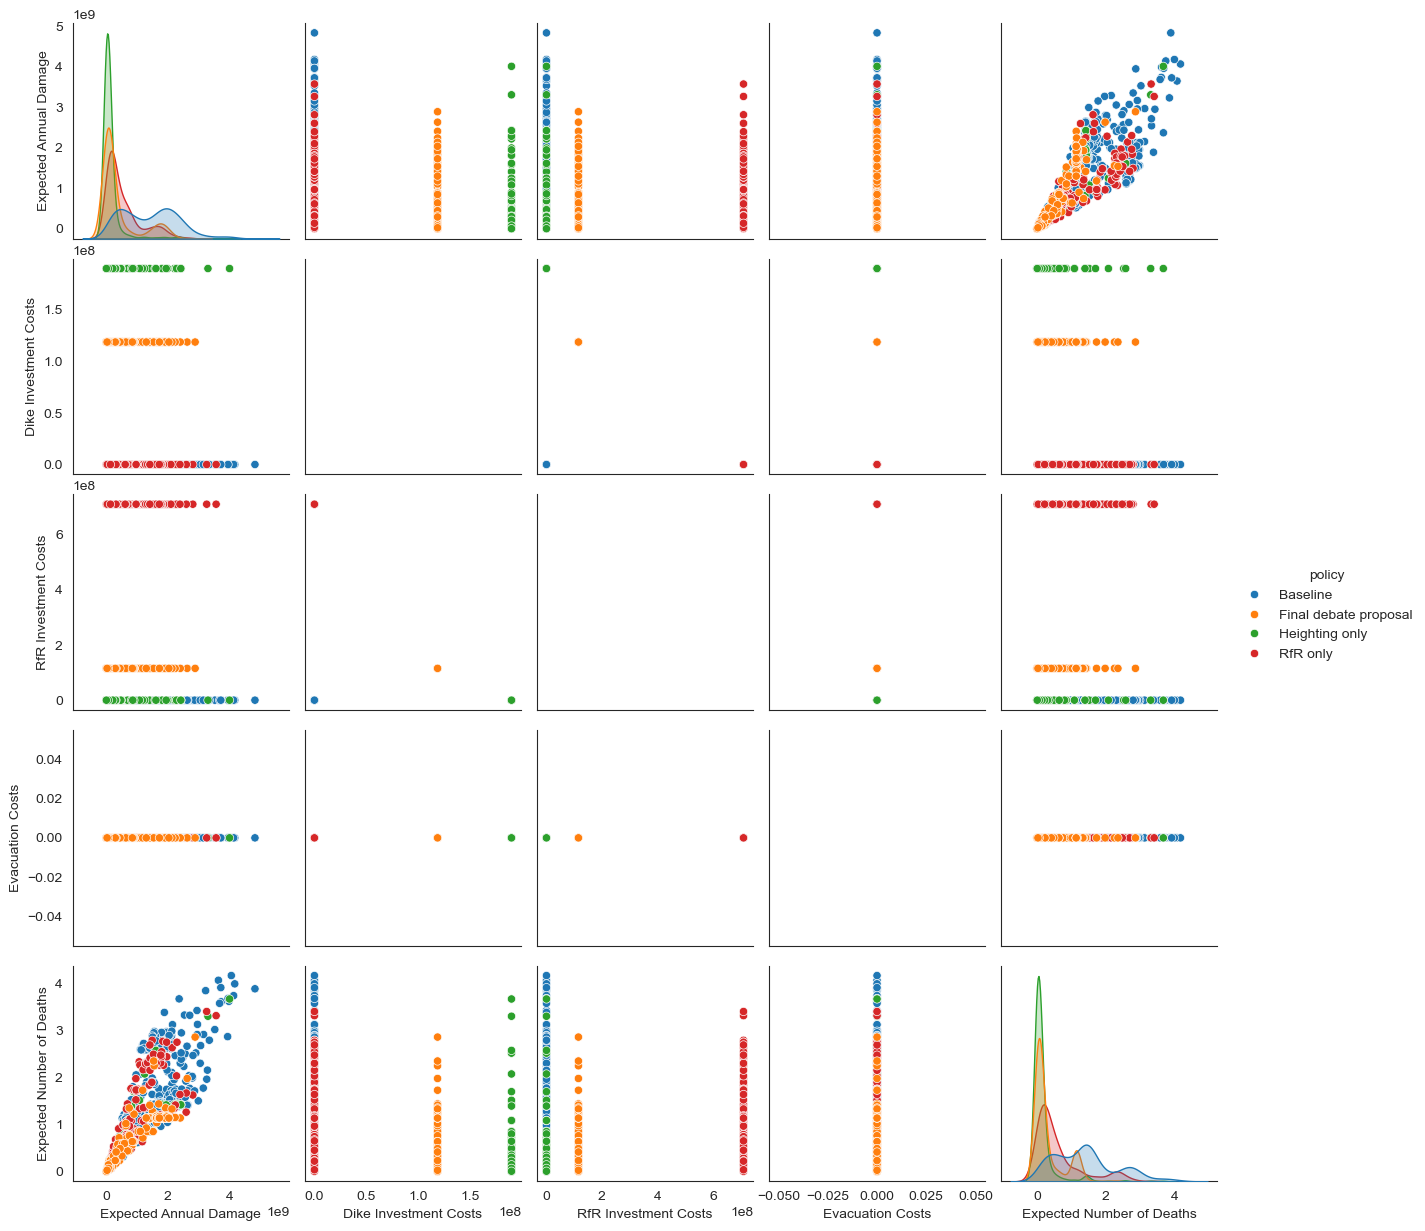

In [20]:
# Visualisation
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

plot = sns.pairplot(data, hue='policy', vars=outcomes.keys(), )
plot.savefig("open_exploration_pf2.png", dpi=300)
plt.show()

[MainProcess/INFO] results loaded successfully from d:\OneDrive\MASTER\02 COURSES\1-2 Model-based Decision-making\Assignment\MBDM_G18\s_d.tar.gz
C:\Users\chest\AppData\Local\Temp\ipykernel_26256\2879614344.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
C:\Users\chest\AppData\Local\Temp\ipykernel_26256\2879614344.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


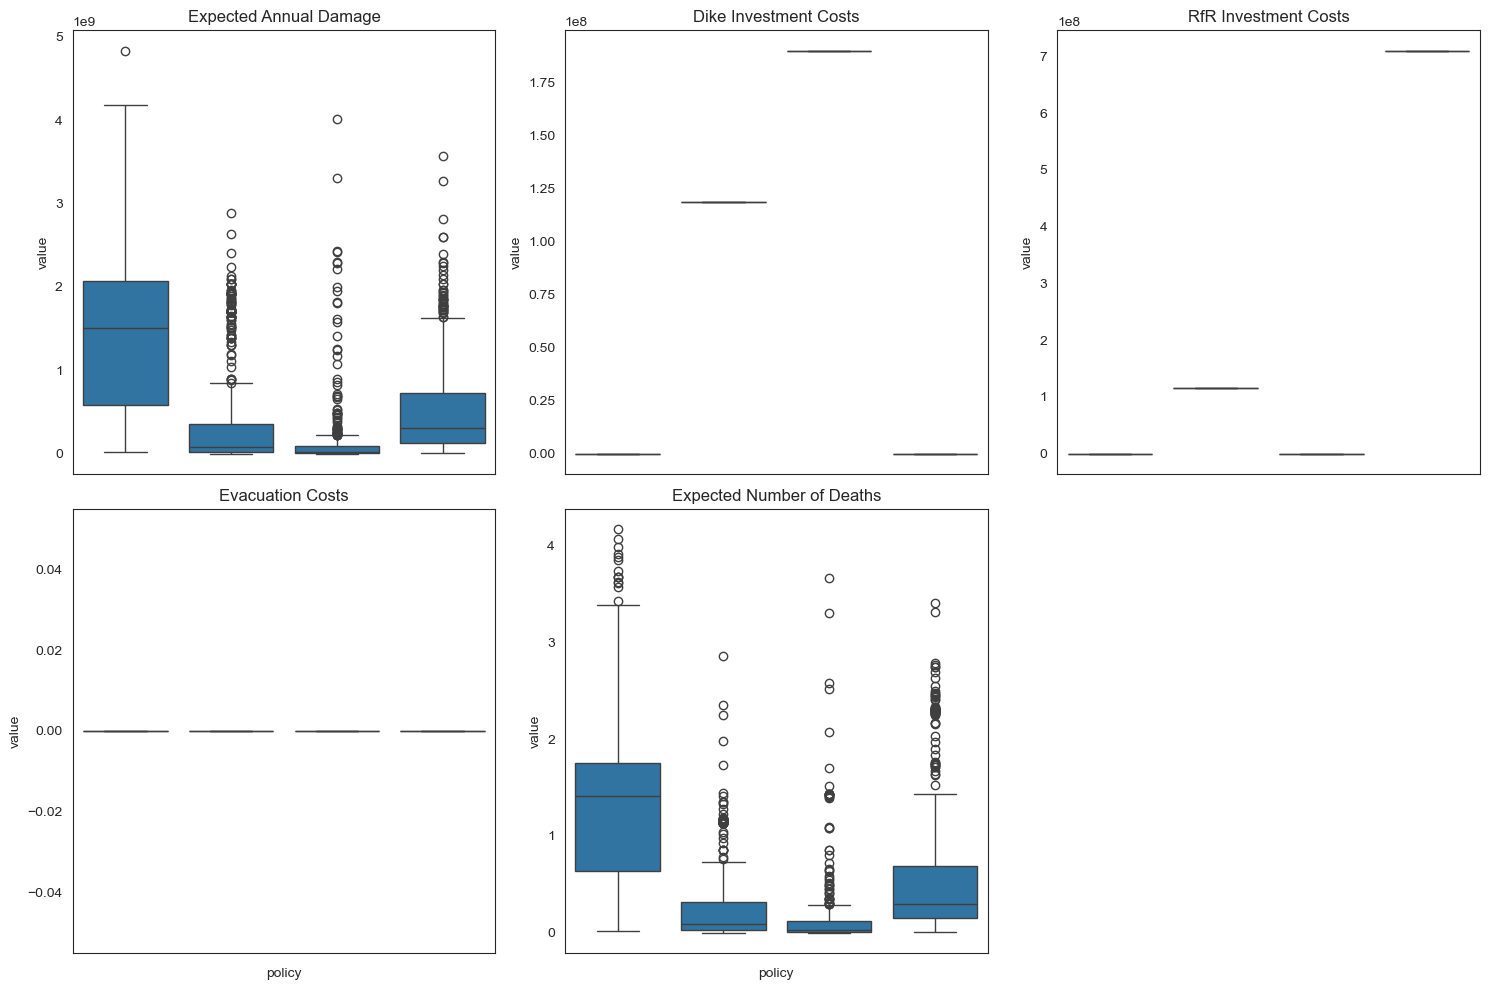

In [65]:

# Load results from the open exploration
experiments, outcomes = load_results('s_d.tar.gz')

# Prepare data for visualization
policies = experiments['policy']
data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

# Melt the DataFrame to long-form for seaborn boxplot
df_melt = pd.melt(data, id_vars='policy')

# Create subplots (2 rows x 3 columns) to accommodate 5 outcomes
f, axes = plt.subplots(2, 3, sharex=True, figsize=(15, 10))


# Unique outcome list with a count to loop through and create a boxplot for each outcome
unq_outcomes = df_melt.variable.unique()
count = 0

# Create boxplots
axes = axes.flatten()
for axs in axes:
    if count < len(unq_outcomes):
        sns.boxplot(x="policy", y="value", data=df_melt.loc[df_melt.variable == unq_outcomes[count]], ax=axs)
        axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
        axs.set_title(unq_outcomes[count])
        count += 1
    else:
        axs.axis('off')  # Hide unused subplots

# Save and show the plot
f.tight_layout()
f.savefig('boxplot.png')
plt.show()


## 2. Optimisation of Policy Strategies

We use the ***Multi-Objective Evolutionary Algorithms (MOEAs)*** to identify and optimise policies under multiple conflicting obejectives, finding a set of Pareto-optimal solutions that balance trade-offs between different objectives.

Results from open exploration are used as a set of initial soluttions.

### 2.1  Search for Candicate Solution (CS)

In [27]:
# Initialisation
ema_logging.log_to_stderr(ema_logging.INFO)                         # log information to the console
experiments, outcomes = load_results('s_d.tar.gz')                  # load results from open exploration
dike_model, planning_steps = get_model_for_problem_formulation(2)   # align with open exploration


# Define reference scenario based on the median values of the open exploration
numerical_experiments_df = pd.DataFrame(experiments).select_dtypes(include=[np.number])
reference_values = numerical_experiments_df.median()

reference_values['discount rate 0'] = 2.5
reference_values['discount rate 1'] = 2.5
reference_values['discount rate 2'] = 2.5


# Create an ordered dictionary for the reference scenario
ordered_reference_values = OrderedDict([
    ('discount rate 0', reference_values['discount rate 0']),
    ('discount rate 1', reference_values['discount rate 1']),
    ('discount rate 2', reference_values['discount rate 2']),
    ('A.0_ID flood wave shape', reference_values['A.0_ID flood wave shape']),
    ('A.1_Bmax', reference_values['A.1_Bmax']),
    ('A.1_pfail', reference_values['A.1_pfail']),
    ('A.1_Brate', reference_values.get('A.1_Brate', 1.5)),  # Use the value from reference_values or a default
    ('A.2_Bmax', reference_values['A.2_Bmax']),
    ('A.2_pfail', reference_values['A.2_pfail']),
    ('A.2_Brate', reference_values.get('A.2_Brate', 1.5)),
    ('A.3_Bmax', reference_values['A.3_Bmax']),
    ('A.3_pfail', reference_values['A.3_pfail']),
    ('A.3_Brate', reference_values.get('A.3_Brate', 1.5)),
    ('A.4_Bmax', reference_values['A.4_Bmax']),
    ('A.4_pfail', reference_values['A.4_pfail']),
    ('A.4_Brate', reference_values.get('A.4_Brate', 1.5)),
    ('A.5_Bmax', reference_values['A.5_Bmax']),
    ('A.5_pfail', reference_values['A.5_pfail']),
    ('A.5_Brate', reference_values.get('A.5_Brate', 1.5))
])


# Create the reference scenario
reference_scenario = Scenario('reference', **ordered_reference_values)
print("Reference scenario defined:", reference_scenario)


[MainProcess/INFO] results loaded successfully from d:\OneDrive\MASTER\02 COURSES\1-2 Model-based Decision-making\Assignment\MBDM_G18\s_d.tar.gz


Reference scenario defined: Scenario({'discount rate 0': 2.5, 'discount rate 1': 2.5, 'discount rate 2': 2.5, 'A.0_ID flood wave shape': 66.0, 'A.1_Bmax': 190.1342386011431, 'A.1_pfail': 0.5008114310435008, 'A.1_Brate': 1.5, 'A.2_Bmax': 189.78237028424235, 'A.2_pfail': 0.4999287460334875, 'A.2_Brate': 1.5, 'A.3_Bmax': 189.93970708867712, 'A.3_pfail': 0.4999045379500341, 'A.3_Brate': 1.5, 'A.4_Bmax': 189.91857635011195, 'A.4_pfail': 0.49942640384842374, 'A.4_Brate': 1.5, 'A.5_Bmax': 189.75182800366673, 'A.5_pfail': 0.5005898042676569, 'A.5_Brate': 1.5})


In [28]:
# Define constrains
# expected_annual_damage_limit = 60000000     # expecred annual damage
dike_investment_costs_limit = 189926453     # dike investment 
rfr_investment_costs_limit = 710400000      # RfR investment

constraints = [
    # Constraint("Expected Annual Damage", outcome_names="Expected Annual Damage",
    #            function=lambda x: max(0, x - expected_annual_damage_limit)),
    Constraint("Dike Investment Costs", outcome_names="Dike Investment Costs",
               function=lambda x: max(0, x - dike_investment_costs_limit)),
    Constraint("RfR Investment Costs", outcome_names="RfR Investment Costs",
               function=lambda x: max(0, x - rfr_investment_costs_limit))
    # Constraint('Expected Number of Deaths', outcome_names='Expected Number of Deaths',
    #            function=lambda x: max(0, x - 0.1))
]


# Run MOEA optimisation
workers = min(multiprocessing.cpu_count(),4)
print(f"Using {workers} workers for parallel processing")

nfe = 20000
convergence_metrics = [EpsilonProgress()]   

with MultiprocessingEvaluator(dike_model, n_processes=workers) as evaluator:
    results = evaluator.optimize(nfe=nfe,                           # number of function evaluations, set to 10000
                                searchover='levers',                # optimise 'levels' (can be 'uncertainties')
                                epsilons=[0.25,]*len(dike_model.outcomes),        # grid resolution for epsilon-dominance
                                convergence=convergence_metrics,    # list of convergence metrics to track
                                constraints=constraints,          # list of constraints to enforce during optimisation
                                reference=reference_scenario        # Reference scenario
                                )    

Using 4 workers for parallel processing


[MainProcess/INFO] pool started with 4 workers
20197it [43:13,  7.79it/s]                                                     
[MainProcess/INFO] optimization completed, found 210 solutions
[MainProcess/INFO] terminating pool


In [36]:
with open('MOEA_20000.pkl', 'wb') as f:
    pickle.dump(results, f)  

In [37]:
with open('MOEA_20000.pkl', 'rb') as f:
    optimisation_results = pickle.load(f)

o_results, convergence = optimisation_results
print(o_results.keys())
print(convergence.keys())

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'Expected Annual Damage', 'Dike Investment Costs',
       'RfR Investment Costs', 'Evacuation Costs',
       'Expected Number of Deaths'],
      dtype='object')
Index(['epsilon_progress', 'nfe'], dtype='object')


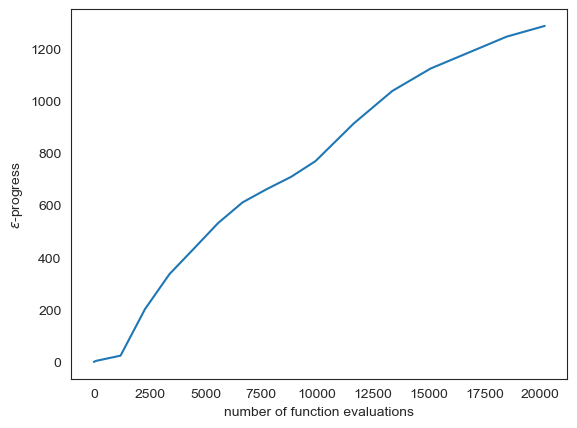

In [38]:
# Visualise convergence, to assess whether the algorithm has converged (how the solution have been improved over time)
fig, ax = plt.subplots()
ax.plot(convergence['nfe'], convergence['epsilon_progress'])
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations')
plt.savefig('convergence_plot.png')
plt.show()


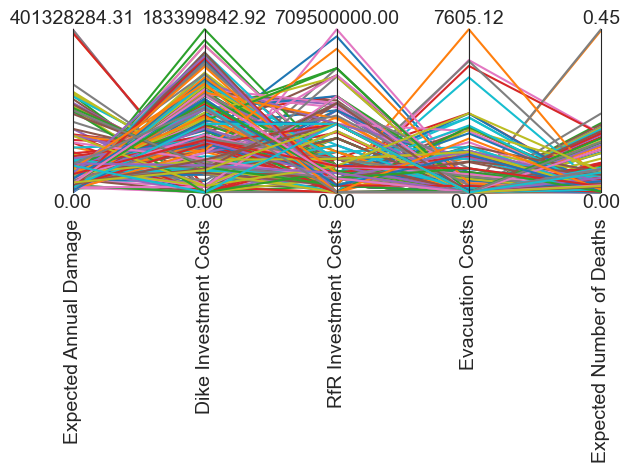

In [39]:
# Visualise results
dike_model, planning_steps = get_model_for_problem_formulation(2)       # choose PF2 for open exploration
o_data = o_results.loc[:, [o.name for o in dike_model.outcomes]]
o_limits = parcoords.get_limits(o_data)

paraxes = parcoords.ParallelAxes(o_limits)
paraxes.plot(o_data)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('parallel_coords.png', dpi=300)
plt.show()

### 2.2 Re-evaluate CS under Uncertainty (Set Threshold)

In [53]:
with open('MOEA_20000.pkl', 'rb') as f:
    optimisation_results = pickle.load(f)

o_results, convergence = optimisation_results
print("Number of policeis:", len(o_results))

policy_0 = o_results[o_results['Expected Number of Deaths'] < 0.001]
print("Number of policies meeting the criteria:", len(policy_0))

Number of policeis: 210
Number of policies meeting the criteria: 15


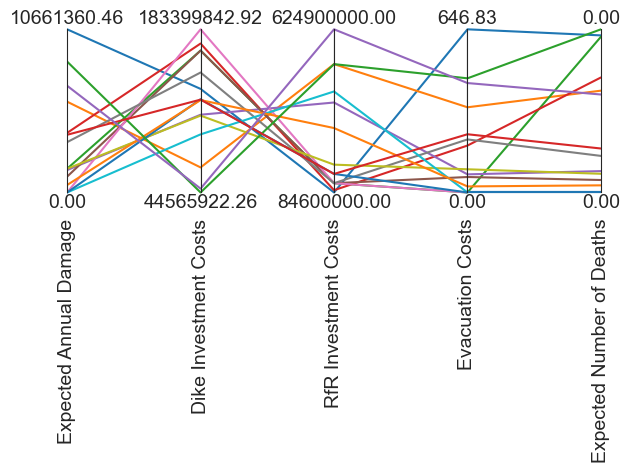

In [41]:
# Visualise results
r_o_data = policy_0.loc[:, [o.name for o in dike_model.outcomes]]
r_o_limits = parcoords.get_limits(r_o_data)

paraxes = parcoords.ParallelAxes(r_o_limits)
paraxes.plot(r_o_data)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('reduced_parallel_coords.png', dpi=300)
plt.show()

### 2.3  Re-search for CS


In [42]:
# Re-evaluation of filtered policies
policies_to_evaluate = policy_0.drop(columns=[o.name for o in dike_model.outcomes]).to_dict(orient='records')
policies_to_evaluate = [Policy(str(i), **policy) for i, policy in enumerate(policies_to_evaluate)]


# Perform re-evaluation with additional scenarios
n_scenarios_re_evaluation = 1000

with MultiprocessingEvaluator(dike_model, n_processes=workers) as evaluator:
    re_eval_results = evaluator.perform_experiments(n_scenarios_re_evaluation, 
                                                        policies_to_evaluate)



[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 1000 scenarios * 15 policies * 1 model(s) = 15000 experiments
100%|████████████████████████████████████| 15000/15000 [28:30<00:00,  8.77it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [45]:
# Save re-evaluation results
save_results(re_eval_results, 're_evaluation_results.tar.gz')

[MainProcess/INFO] results saved successfully to d:\OneDrive\MASTER\02 COURSES\1-2 Model-based Decision-making\Assignment\MBDM_G18\re_evaluation_results.tar.gz


[MainProcess/INFO] results loaded successfully from d:\OneDrive\MASTER\02 COURSES\1-2 Model-based Decision-making\Assignment\MBDM_G18\re_evaluation_results.tar.gz


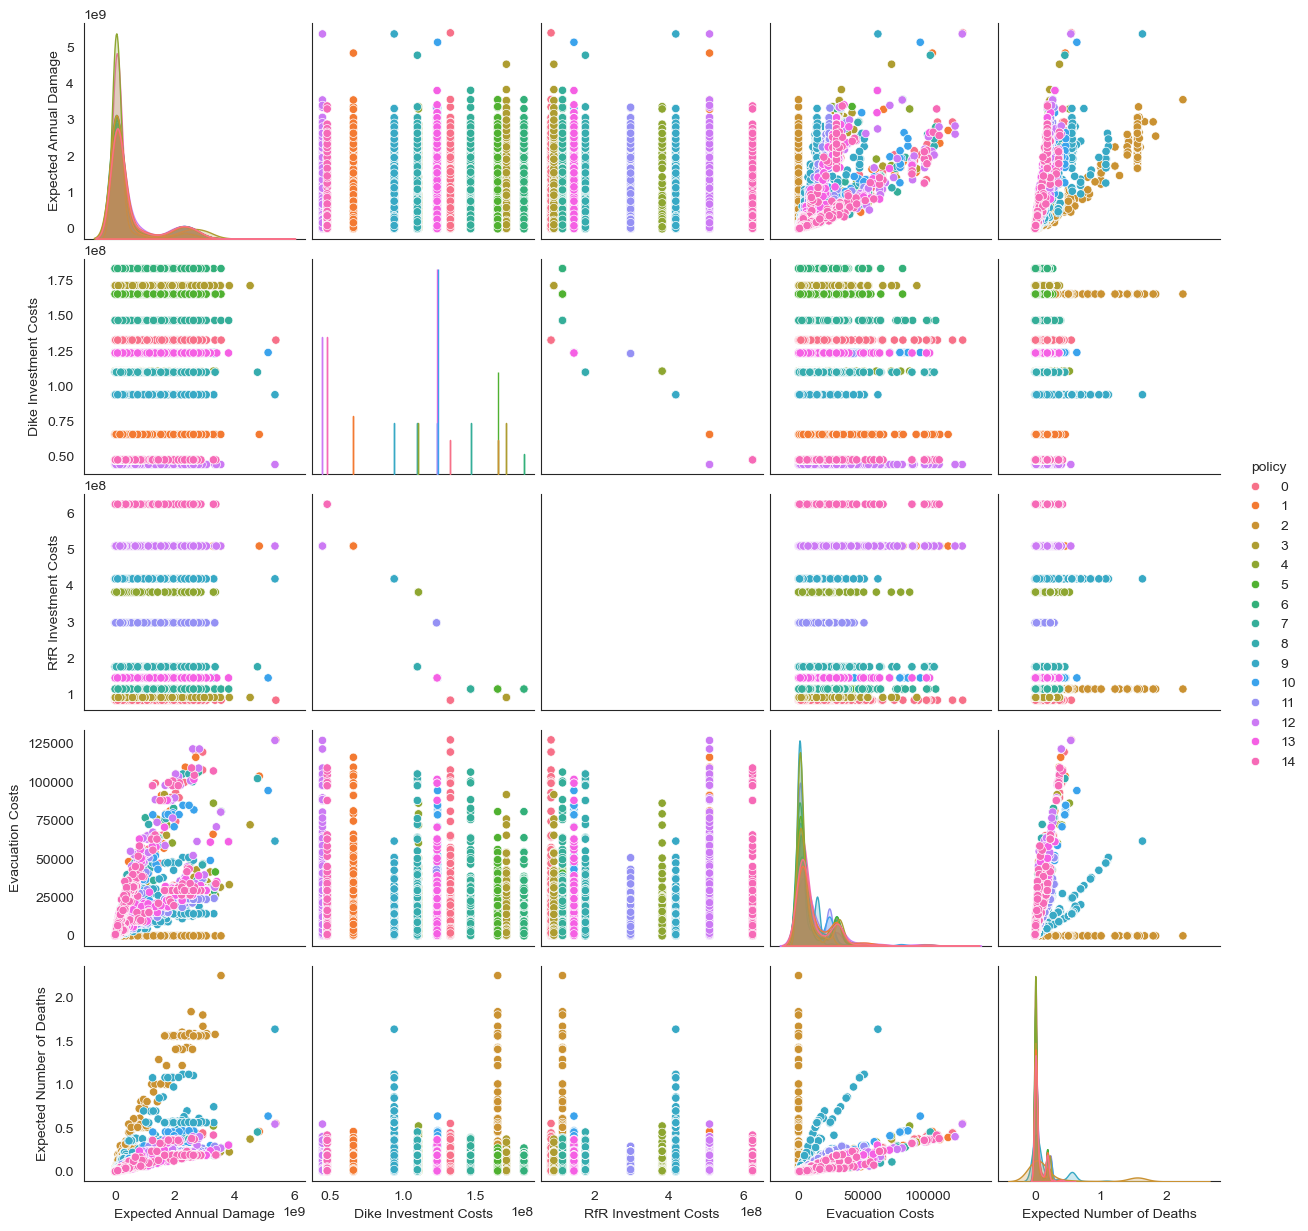

In [46]:
# Visualisation
experiments_re_eval, outcomes_re_eval = load_results('re_evaluation_results.tar.gz') 
policies_re_eval = experiments_re_eval['policy']

data = pd.DataFrame.from_dict(outcomes_re_eval)
data['policy'] = policies_re_eval

plot = sns.pairplot(data, hue='policy', vars=outcomes_re_eval.keys(), )
plot.savefig("re_cs_pf2.png", dpi=300)
plt.show()

## 3. Scenario Discovery and Robustness Assessment

We conduct ***Scenario Discovery (PRIM)*** and ***Robustness Assessment (Maximum Regret)*** after MOEA to provide post-optimisation insights, including the conditions leading to success and the robustness of policies under uncertainty.

***PRIM*** can help identify the  the conditions (uncertainties) under which policies are successful or fail.

In [2]:
# Load results from open exploration
experiments_re_eval, outcomes_re_eval = load_results('re_evaluation_results.tar.gz')                  

print(experiments_re_eval.keys())
print(outcomes_re_eval.keys())

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2', 'scenario', 'policy', 'model'],
      dtype='object')
dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 15000 points remaining, containing 2318 cases of interest
[MainProcess/INFO] mean: 0.856, mass: 0.05, coverage: 0.27696289905090593, density: 0.856 restricted_dimensions: 10


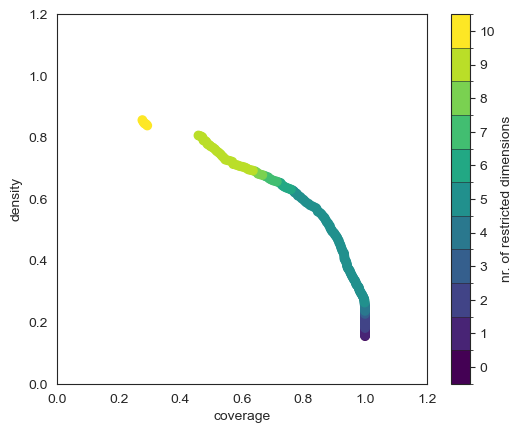

coverage       0.800259
density        0.597424
id           140.000000
k           1855.000000
mass           0.207000
mean           0.597424
n           3105.000000
res_dim        5.000000
Name: 140, dtype: float64

            box 140                                  
                min       max       qp value qp value
A.1_pfail  0.391388  0.999464  9.980197e-125      NaN
A.2_pfail  0.305914  0.999789   1.752268e-76      NaN
A.3_pfail  0.313012  0.999759   8.986467e-68      NaN
A.5_pfail  0.146658  0.999363   2.769787e-27      NaN
A.4_pfail  0.156923  0.999604   1.053282e-19      NaN



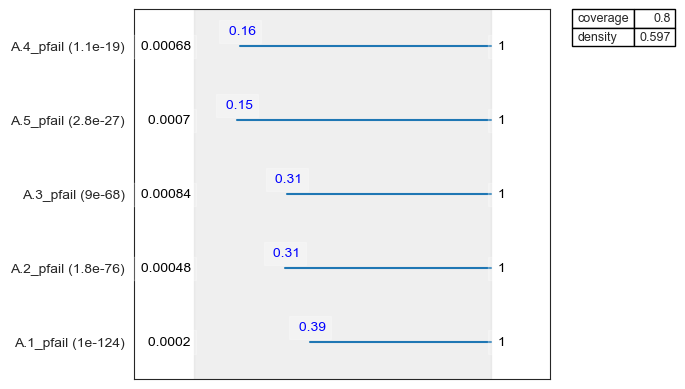

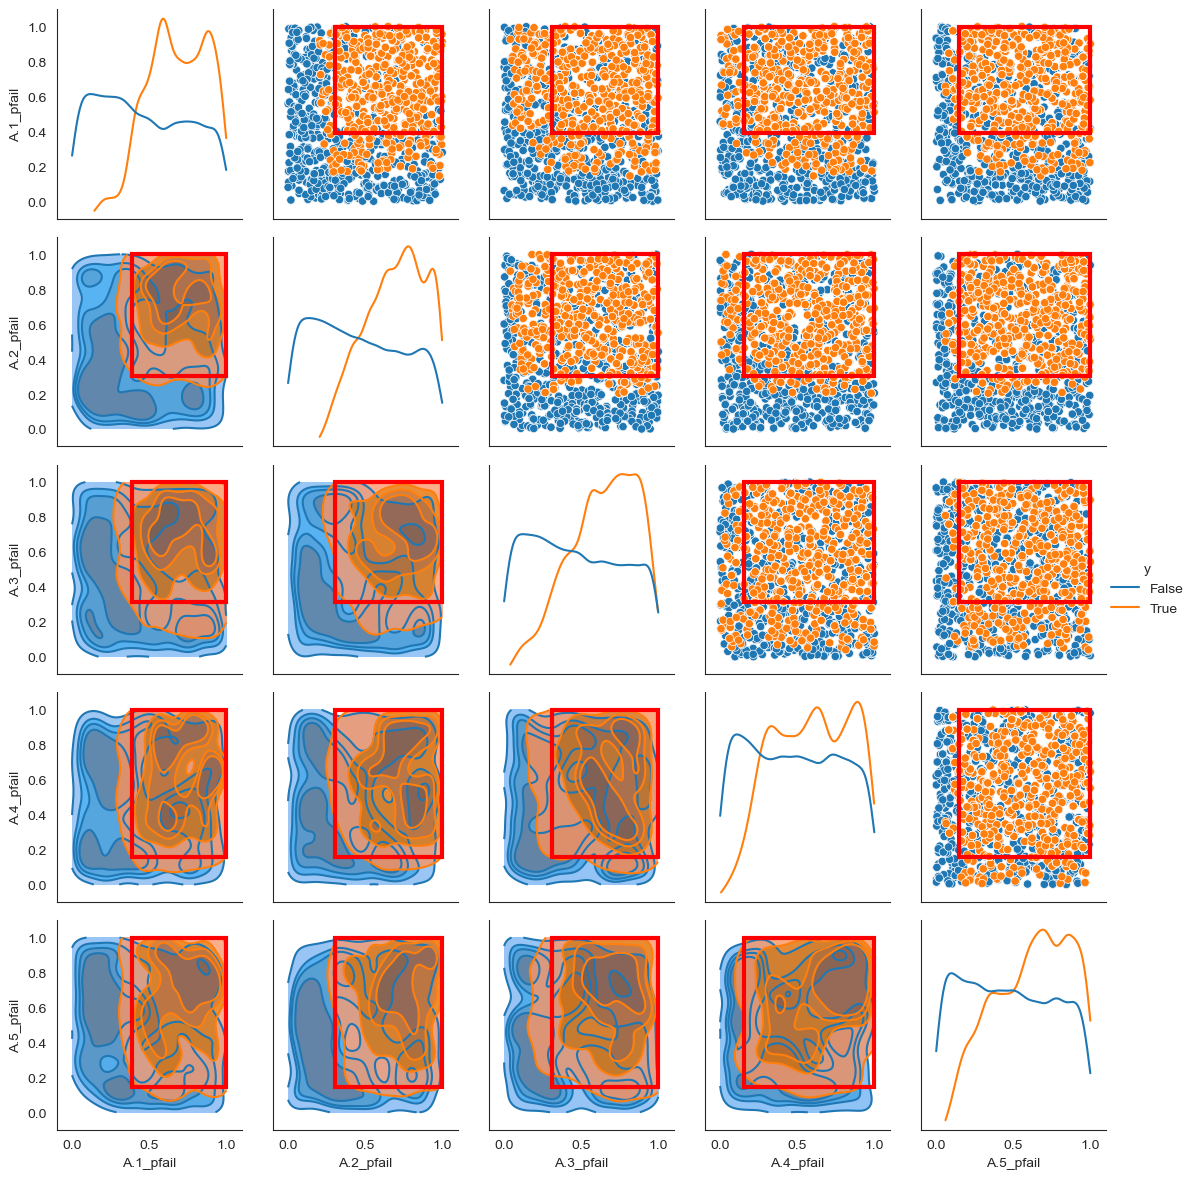

In [48]:
# Clean the experiments for PRIM analysis
experiments_noDI = experiments_re_eval.drop(labels=[
    'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
    'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
    'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
    'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
    'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', 
    'policy'
], axis=1)

cleaned_experiments = experiments_noDI.drop(labels=[
    '0_RfR 0', '0_RfR 1', '0_RfR 2',
    '1_RfR 0', '1_RfR 1', '1_RfR 2',
    '2_RfR 0', '2_RfR 1', '2_RfR 2',
    '3_RfR 0', '3_RfR 1', '3_RfR 2',
    '4_RfR 0', '4_RfR 1', '4_RfR 2',
    'EWS_DaysToThreat'
], axis=1)


# Define the objective function for PRIM analysis
y = (
    # (outcomes_re_eval['Expected Annual Damage'] == 0) &
    # (outcomes_re_eval['Dike Investment Costs'] <= 118690000) &
    # (outcomes_re_eval['RfR Investment Costs'] <= 115300000) &
    (outcomes_re_eval['Expected Number of Deaths'] < 0.001)
)


# Perform PRIM analysis
prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.5, peel_alpha=0.01)
box = prim_alg.find_box()


# Visualize PRIM results
box.show_tradeoff()
plt.savefig('prim_tradeoff_density_coverage.png')
plt.show()

box.inspect(140)
box.inspect(140, style='graph')
plt.savefig('prim_ranges_of_uncertainties.png')
plt.show()

box.select(140)
box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.savefig('prim_scatter_plots.png')
plt.show()

In [49]:
# Extract the scenarios and outcomes within the PRIM box
selected_experiments = experiments_re_eval.iloc[box.yi]
selected_outcomes = {key: values[box.yi] for key, values in outcomes_re_eval.items()}


# Print the outcomes of the selected scenarios
print("Outcomes of the scenarios within the PRIM box:")
for outcome, values in selected_outcomes.items():
    print(f"{outcome}: {values.mean()}")  # Print the mean outcome values


# Extract and print the lever values for the selected scenarios in PRIM
lever_columns = [
    '0_RfR 0', '0_RfR 1', '0_RfR 2',
    '1_RfR 0', '1_RfR 1', '1_RfR 2',
    '2_RfR 0', '2_RfR 1', '2_RfR 2',
    '3_RfR 0', '3_RfR 1', '3_RfR 2',
    '4_RfR 0', '4_RfR 1', '4_RfR 2',
    'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
    'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
    'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
    'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
    'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'
]

selected_levers = selected_experiments[lever_columns]
print("Lever values for the selected scenarios within the PRIM box:")
print(selected_levers.mean())

Outcomes of the scenarios within the PRIM box:
Expected Annual Damage: 10345884.919537067
Dike Investment Costs: 120552813.24464479
RfR Investment Costs: 256680000.0
Evacuation Costs: 576.9011300328972
Expected Number of Deaths: 0.0015732779292343874
Lever values for the selected scenarios within the PRIM box:
0_RfR 0               0.333333
0_RfR 1               0.266667
0_RfR 2               0.466667
1_RfR 0               0.000000
1_RfR 1               0.000000
1_RfR 2               0.000000
2_RfR 0               0.666667
2_RfR 1               0.600000
2_RfR 2               0.733333
3_RfR 0               0.333333
3_RfR 1               0.266667
3_RfR 2               0.266667
4_RfR 0               0.000000
4_RfR 1               0.000000
4_RfR 2               0.000000
A.1_DikeIncrease 0    0.133333
A.1_DikeIncrease 1    0.000000
A.1_DikeIncrease 2    0.000000
A.2_DikeIncrease 0    2.400000
A.2_DikeIncrease 1    0.266667
A.2_DikeIncrease 2    0.000000
A.3_DikeIncrease 0    2.466667
A.3_Di

***Maximum Regret*** can evaluate the robustness of policies by examining the worst-case performance relative to the best possible performance in each scenario.

The policy with the lowest maximum regret is: 11 with a regret value of: 705591562.606822
Outcomes of the best policy 11:
Expected Annual Damage: 447897348.61394143
Dike Investment Costs: 123185672.89840692
RfR Investment Costs: 297900000.0
Evacuation Costs: 6541.074335250799
Expected Number of Deaths: 0.04669608296240944


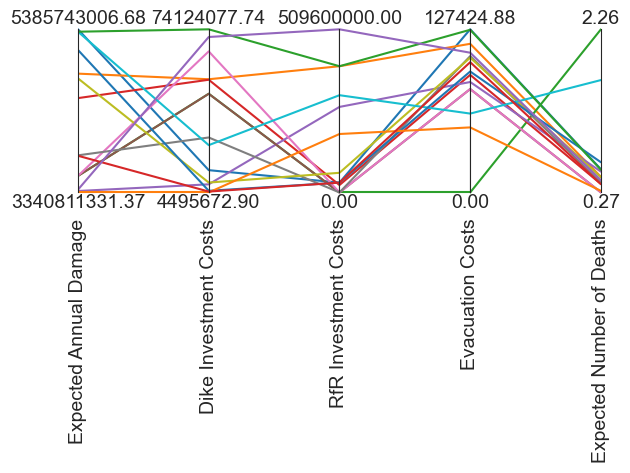

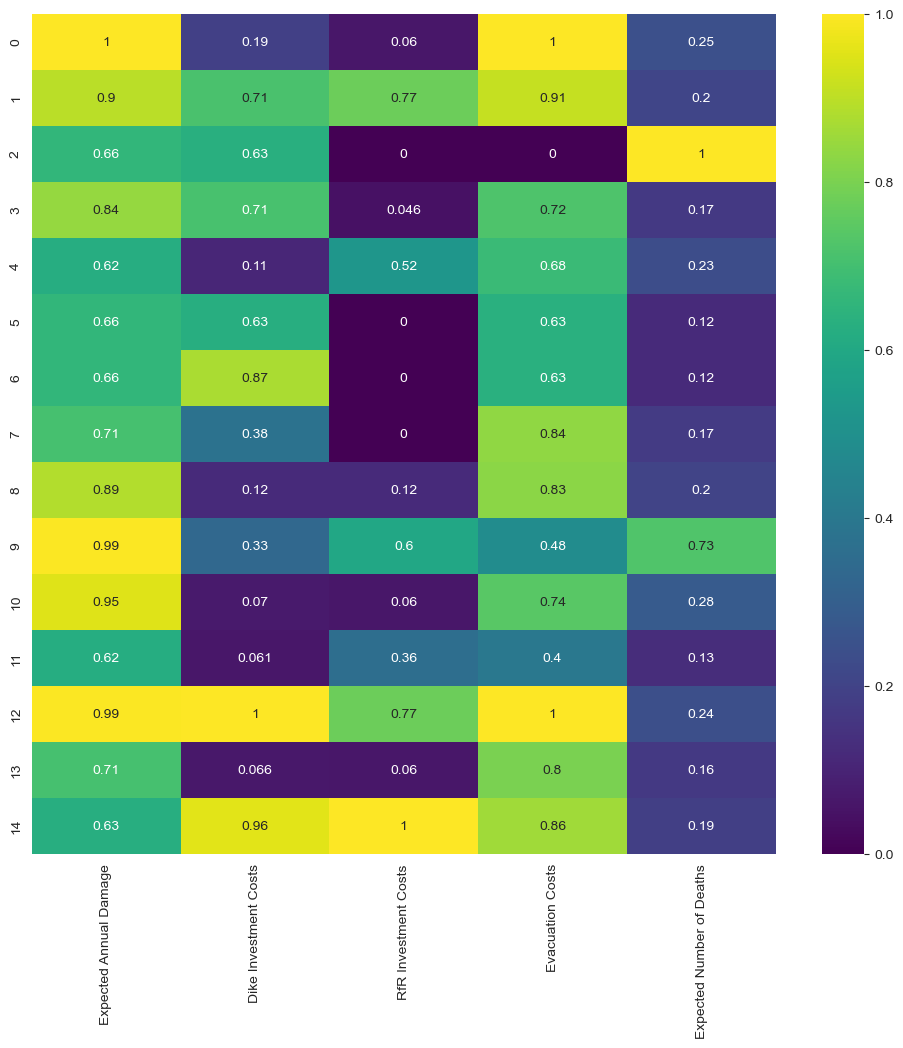

In [4]:
# Define function to calculate regret
def calculate_regret(outcomes, best_outcome):
    regret = {key: np.max(np.abs(values - best_outcome[key])) for key, values in outcomes.items()}
    return regret


# Load re-evaluation results
experiments_re_eval, outcomes_re_eval = load_results('re_evaluation_results.tar.gz')


# Define the realistic best outcomes
dike_investment_costs_limit = 118690000     # dike investment from final debate
rfr_investment_costs_limit = 115300000      # RfR investment from final debate

best_outcome = {
    "Expected Annual Damage": 0,
    "Dike Investment Costs": dike_investment_costs_limit,
    "RfR Investment Costs": rfr_investment_costs_limit,
    "Expected Number of Deaths": 0,
    "Evacuation Costs": 0                   # Assuming the best outcome for Evacuation Costs is also 0
}


# Calculate maximum regret for each policy
max_regret = {}
for policy in experiments_re_eval['policy'].unique():
    policy_outcomes = {key: values[experiments_re_eval['policy'] == policy] for key, values in outcomes_re_eval.items()}
    max_regret[policy] = calculate_regret(policy_outcomes, best_outcome)


# Convert the max_regret dictionary to a DataFrame
max_regret_df = pd.DataFrame(max_regret).T


# Find the policy with the lowest maximum regret
min_max_regret_policy = max_regret_df.mean(axis=1).idxmin()
min_max_regret_value = max_regret_df.mean(axis=1).min()

print(f"The policy with the lowest maximum regret is: {min_max_regret_policy} with a regret value of: {min_max_regret_value}")


# Print the outcomes of the best policy
best_policy_outcomes = {key: values[experiments_re_eval['policy'] == min_max_regret_policy] for key, values in outcomes_re_eval.items()}
print(f"Outcomes of the best policy {min_max_regret_policy}:")
for outcome, values in best_policy_outcomes.items():
    print(f"{outcome}: {values.mean()}")  # Print the mean outcome values


# Plot trade-offs on a parallel plot
limits = parcoords.get_limits(max_regret_df)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(max_regret_df)
plt.savefig('max_regret_parallel_plot.png')
plt.show()


# Create a heatmap for regret values
plt.figure(figsize=(12, 14))
sns.heatmap(max_regret_df / max_regret_df.max(), annot=True, cmap='viridis')
plt.subplots_adjust(bottom=0.28)
plt.savefig('heatmap_regret.png')
plt.show()



In [60]:
# Extract and print the lever values for the best policy
lever_columns = [
    '0_RfR 0', '0_RfR 1', '0_RfR 2',
    '1_RfR 0', '1_RfR 1', '1_RfR 2',
    '2_RfR 0', '2_RfR 1', '2_RfR 2',
    '3_RfR 0', '3_RfR 1', '3_RfR 2',
    '4_RfR 0', '4_RfR 1', '4_RfR 2',
    'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
    'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
    'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
    'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
    'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'
]
best_policy_levers = experiments_re_eval[experiments_re_eval['policy'] == min_max_regret_policy][lever_columns]
print(f"Lever values for the best policy {min_max_regret_policy}:")
print(best_policy_levers.mean())

Lever values for the best policy 11:
0_RfR 0               1.0
0_RfR 1               0.0
0_RfR 2               0.0
1_RfR 0               0.0
1_RfR 1               0.0
1_RfR 2               0.0
2_RfR 0               1.0
2_RfR 1               1.0
2_RfR 2               1.0
3_RfR 0               1.0
3_RfR 1               0.0
3_RfR 2               0.0
4_RfR 0               0.0
4_RfR 1               0.0
4_RfR 2               0.0
A.1_DikeIncrease 0    0.0
A.1_DikeIncrease 1    0.0
A.1_DikeIncrease 2    0.0
A.2_DikeIncrease 0    3.0
A.2_DikeIncrease 1    0.0
A.2_DikeIncrease 2    0.0
A.3_DikeIncrease 0    3.0
A.3_DikeIncrease 1    0.0
A.3_DikeIncrease 2    0.0
A.4_DikeIncrease 0    2.0
A.4_DikeIncrease 1    6.0
A.4_DikeIncrease 2    0.0
A.5_DikeIncrease 0    3.0
A.5_DikeIncrease 1    0.0
A.5_DikeIncrease 2    0.0
dtype: float64
